In [133]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import math

In [169]:
import warnings
warnings.filterwarnings("ignore")

# Estimating Jackpot Variance on GGPoker

In [181]:
def plot_jackpot_simulation(
    num_simulations=100_000,
    step_size=5000,
    max_hands=1_000_000,
    p_main=1/550_000,
    p_side=1/550_000,
    p_part=4/550_000,
    payout_main=6000,
    payout_side=2000,
    payout_part=500,
    num_paths=1000,
    seed=None
):
    if seed is not None:
        np.random.seed(seed)

    num_colored_random = 18

    steps = np.arange(step_size, max_hands + 1, step_size)

    ev_list = []
    ci70_low, ci70_high = [], []
    ci95_low, ci95_high = [], []

    for n_hands in steps:
        main_hits = np.random.binomial(n=n_hands, p=p_main, size=num_simulations)
        side_hits = np.random.binomial(n=n_hands, p=p_side, size=num_simulations)
        part_hits = np.random.binomial(n=n_hands, p=p_part, size=num_simulations)

        rewards = (main_hits * payout_main +
                   side_hits * payout_side +
                   part_hits * payout_part)

        ev_list.append(np.mean(rewards))
        ci70_low.append(np.percentile(rewards, 15))
        ci70_high.append(np.percentile(rewards, 85))
        ci95_low.append(np.percentile(rewards, 2.5))
        ci95_high.append(np.percentile(rewards, 97.5))

    all_paths = np.zeros((num_paths, len(steps)))
    for i in range(num_paths):
        cumulative = 0
        path = []
        for _ in steps:
            main = np.random.binomial(step_size, p_main)
            side = np.random.binomial(step_size, p_side)
            part = np.random.binomial(step_size, p_part)
            reward = main * payout_main + side * payout_side + part * payout_part
            cumulative += reward
            path.append(cumulative)
        all_paths[i] = path

    max_idx = np.argmax(all_paths[:, -1])
    min_idx = np.argmin(all_paths[:, -1])

    remaining_indices = list(set(range(num_paths)) - {max_idx, min_idx})
    if num_colored_random > len(remaining_indices):
        raise ValueError(f"num_colored_random={num_colored_random} is too large for the number of available paths")

    random_18_indices = np.random.choice(remaining_indices, size=num_colored_random, replace=False)

    # Final statistics for max_hands
    total_hands = steps[-1]
    ev = ev_list[-1]
    stddev = np.std((np.random.binomial(n=total_hands, p=p_main, size=num_simulations) * payout_main +
                     np.random.binomial(n=total_hands, p=p_side, size=num_simulations) * payout_side +
                     np.random.binomial(n=total_hands, p=p_part, size=num_simulations) * payout_part))
    stddev_per_100 = stddev / (total_hands / 100)  # variance per 100 hands

    ci70 = (ci70_low[-1], ci70_high[-1])
    ci95 = (ci95_low[-1], ci95_high[-1])
    ci70_per_100 = (ci70[0] / (total_hands / 100), ci70[1] / (total_hands / 100))
    ci95_per_100 = (ci95[0] / (total_hands / 100), ci95[1] / (total_hands / 100))

    print(f"Hands played: {total_hands}")
    print(f"Expected Value (EV): {ev:.2f} BB")
    print(f"Standard Deviation after {total_hands} hands: {stddev:.2f} BB ({stddev_per_100:.2f} BB/100 hands)")
    print(f"70% Confidence Interval: [{ci70[0]:.2f}, {ci70[1]:.2f}] BB "
          f"([{ci70_per_100[0]:.3f}, {ci70_per_100[1]:.3f}] BB/100 hands)")
    print(f"95% Confidence Interval: [{ci95[0]:.2f}, {ci95[1]:.2f}] BB "
          f"([{ci95_per_100[0]:.3f}, {ci95_per_100[1]:.3f}] BB/100 hands)")

    # Plotting
    plt.figure(figsize=(14, 8))
    plt.plot(steps, ev_list, label="EV", color='black', linewidth=2)
    plt.fill_between(steps, ci95_low, ci95_high, color='green', alpha=0.2, label="95% CI")
    plt.fill_between(steps, ci70_low, ci70_high, color='lime', alpha=0.3, label="70% CI")
    
    colors = cm.get_cmap('tab20', num_colored_random)
    for idx, i in enumerate(random_18_indices):
        plt.plot(steps, all_paths[i], color=colors(idx), alpha=1, linewidth=1)
    
    plt.plot(steps, all_paths[max_idx], color='red', linewidth=2, label="Best run out of 1000 trials")
    plt.plot(steps, all_paths[min_idx], color='blue', linewidth=2, label="Worst run out of 1000 trials")
    
    plt.title("Jackpot winnings over distance with confidence intervals")
    plt.xlabel("Hands played")
    plt.ylabel("Total winnings (in BB)")
    
    # Axis formatting
    ax = plt.gca()
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y):,}'))
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #return {
    #    'hands': total_hands,
    #    'ev': ev,
    #    'stddev': stddev,
    #    'stddev_per_100': stddev_per_100,
    #    'ci70': ci70,
    #    'ci95': ci95,
    #}


Hands played: 1000000
Expected Value (EV): 18134.15 BB
Standard Deviation after 1000000 hands: 8663.58 BB (0.87 BB/100 hands)
70% Confidence Interval: [9500.00, 27000.00] BB ([0.950, 2.700] BB/100 hands)
95% Confidence Interval: [4000.00, 37500.00] BB ([0.400, 3.750] BB/100 hands)


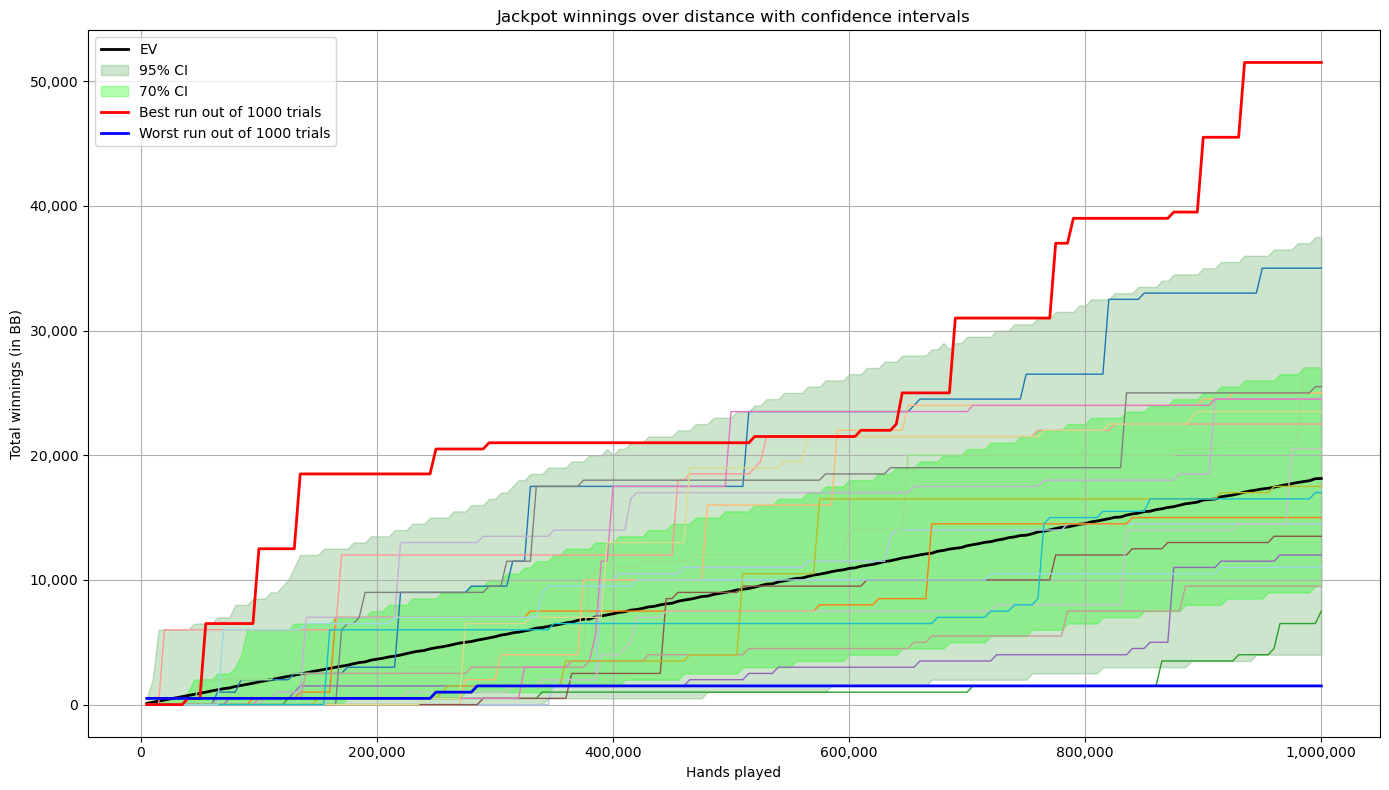

In [183]:
plot_jackpot_simulation(seed=42)

Hands played: 5000000
Expected Value (EV): 90799.66 BB
Standard Deviation after 5000000 hands: 19257.77 BB (0.39 BB/100 hands)
70% Confidence Interval: [71000.00, 111000.00] BB ([1.420, 2.220] BB/100 hands)
95% Confidence Interval: [56000.00, 131000.00] BB ([1.120, 2.620] BB/100 hands)


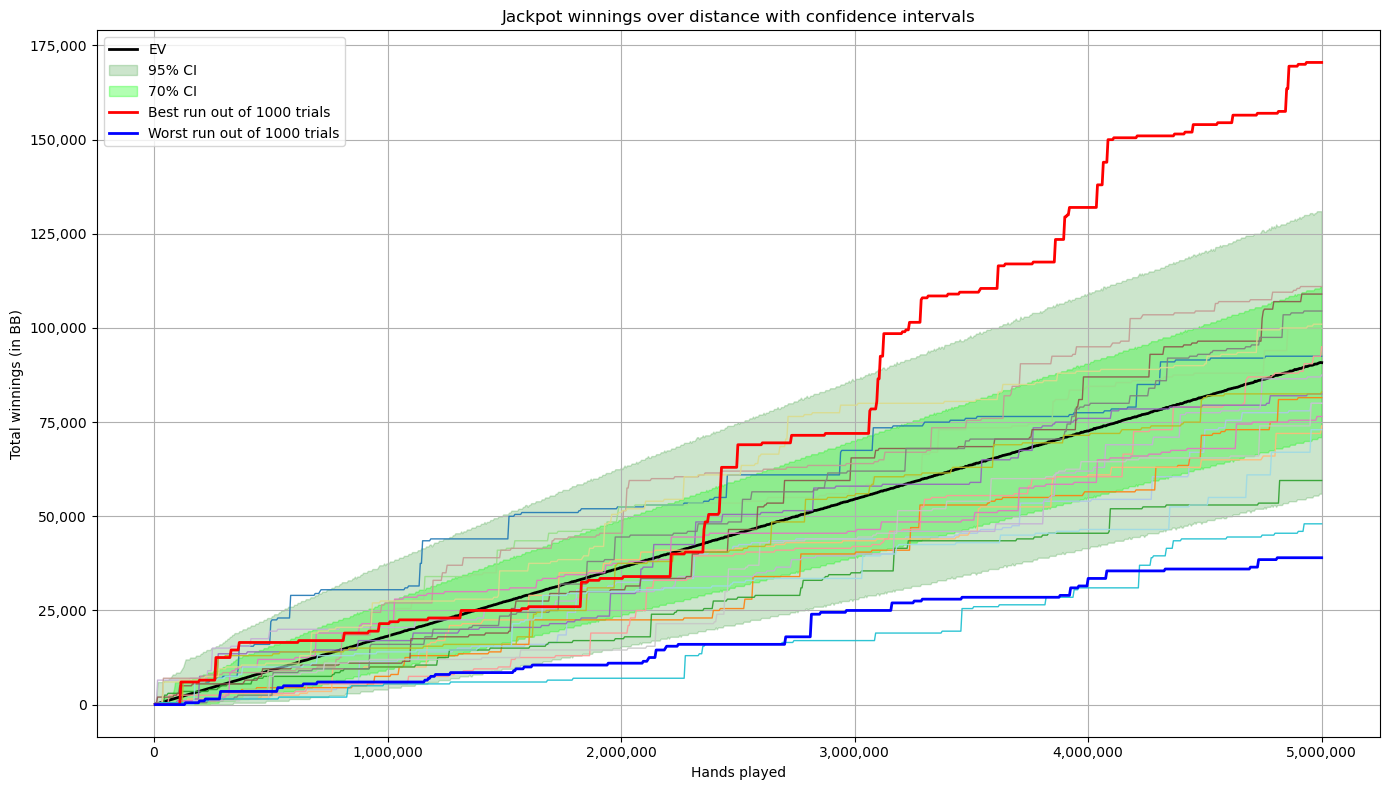

In [177]:
plot_jackpot_simulation(max_hands = 5_000_000)

# Distribution of Jackpot Winnings

Expected winnings: 181.82 buy-ins
Variance: 7461.32
Standard deviation: 86.38
95% confidence interval: [40.00, 375.00]


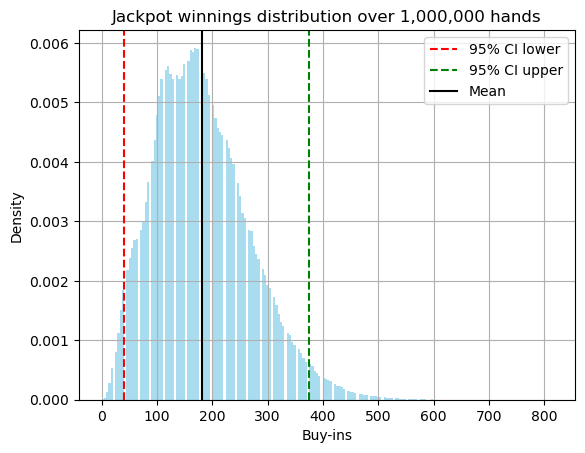

In [155]:
# Parameters
num_simulations = 500000
num_hands = 1000000

# Probabilities of hitting (once every 550k hands)
p_main = 1 / 550_000
p_side = 1 / 550_000
p_participation = 4 / 550_000

# Payouts
payout_main = 60
payout_side = 20
payout_participation = 5

# Simulations
main_hits = np.random.binomial(n=num_hands, p=p_main, size=num_simulations)
side_hits = np.random.binomial(n=num_hands, p=p_side, size=num_simulations)
part_hits = np.random.binomial(n=num_hands, p=p_participation, size=num_simulations)

# Total winnings in buy-ins per simulation
total_rewards = (
    main_hits * payout_main +
    side_hits * payout_side +
    part_hits * payout_participation
)

# Results
mean_reward = np.mean(total_rewards)
variance = np.var(total_rewards)
std_dev = np.std(total_rewards)
ci_lower, ci_upper = np.percentile(total_rewards, [2.5, 97.5])

# Output
print(f"Expected winnings: {mean_reward:.2f} buy-ins")
print(f"Variance: {variance:.2f}")
print(f"Standard deviation: {std_dev:.2f}")
print(f"95% confidence interval: [{ci_lower:.2f}, {ci_upper:.2f}]")

# Visualization
plt.hist(total_rewards, bins=200, density=True, alpha=0.7, color='skyblue')
plt.axvline(ci_lower, color='red', linestyle='--', label='95% CI lower')
plt.axvline(ci_upper, color='green', linestyle='--', label='95% CI upper')
plt.axvline(mean_reward, color='black', linestyle='-', label='Mean')
plt.title(f'Jackpot winnings distribution over {num_hands:,} hands')
plt.xlabel('Buy-ins')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [202]:
std_total_bb = std_dev * 100
std_bb_per_100 = std_total_bb / np.sqrt(num_hands / 100)

print("="*51)
print(f"  Standard deviation from jackpots ≈ {std_bb_per_100:.2f} BB/100")
print("="*51)

  Standard deviation from jackpots ≈ 86.38 BB/100


In [141]:
std_from_jacks = std_bb_per_100
std_from_game_values = [70, 80, 90, 100]

for std_from_game in std_from_game_values:
    total_std = math.sqrt(std_from_game**2 + std_from_jacks**2)
    print(f"std_from_game = {std_from_game} BB/100 -> total_std = {total_std:.2f} BB/100")

std_from_game = 70 BB/100 -> total_std = 110.96 BB/100
std_from_game = 80 BB/100 -> total_std = 117.52 BB/100
std_from_game = 90 BB/100 -> total_std = 124.55 BB/100
std_from_game = 100 BB/100 -> total_std = 131.95 BB/100


### Here are some more graphs with random samples

Hands played: 1000000
Expected Value (EV): 18142.89 BB
Standard Deviation after 1000000 hands: 8607.32 BB (0.86 BB/100 hands)
70% Confidence Interval: [9500.00, 27000.00] BB ([0.950, 2.700] BB/100 hands)
95% Confidence Interval: [4000.00, 37500.00] BB ([0.400, 3.750] BB/100 hands)


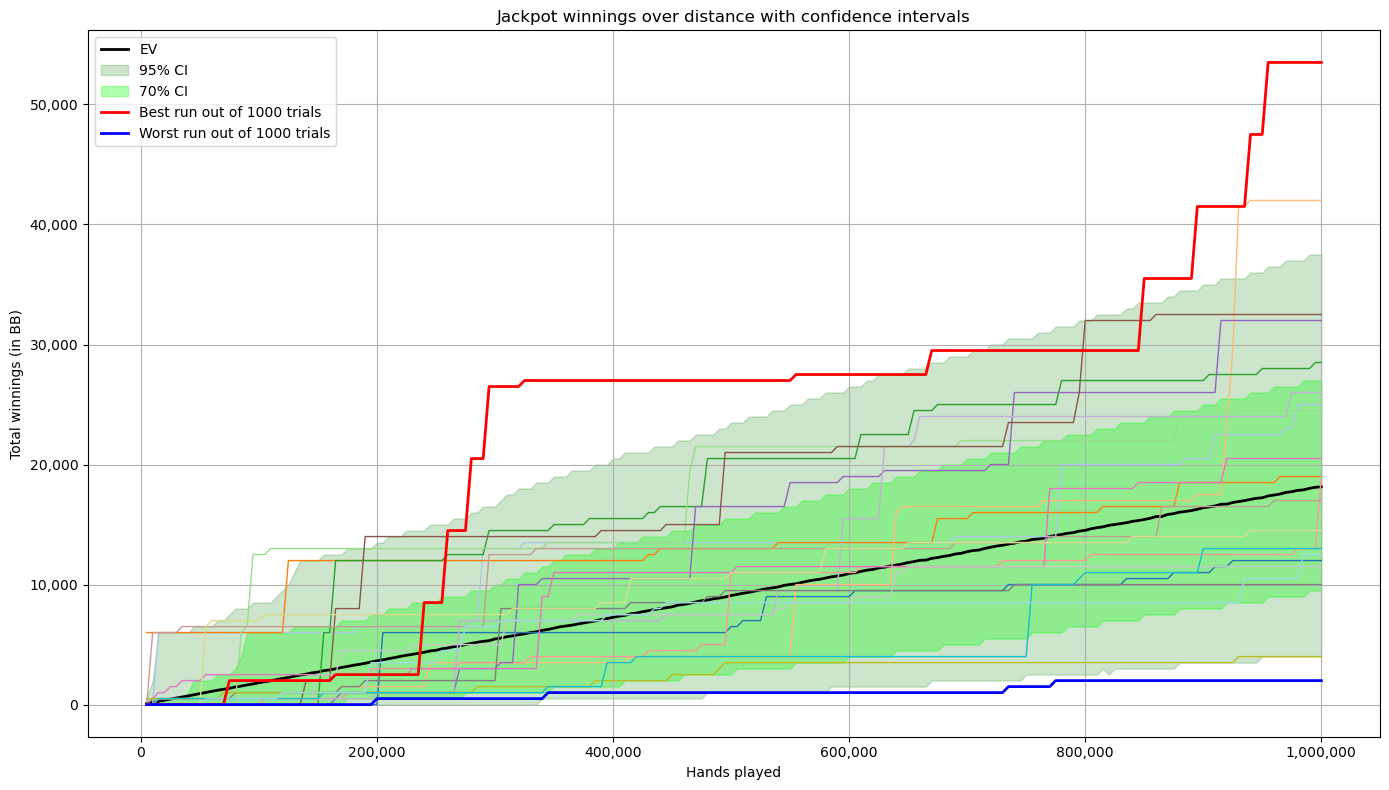

In [213]:
plot_jackpot_simulation(seed=52)

Hands played: 2500000
Expected Value (EV): 45377.11 BB
Standard Deviation after 2500000 hands: 13663.07 BB (0.55 BB/100 hands)
70% Confidence Interval: [31500.00, 59500.00] BB ([1.260, 2.380] BB/100 hands)
95% Confidence Interval: [21500.00, 75000.00] BB ([0.860, 3.000] BB/100 hands)


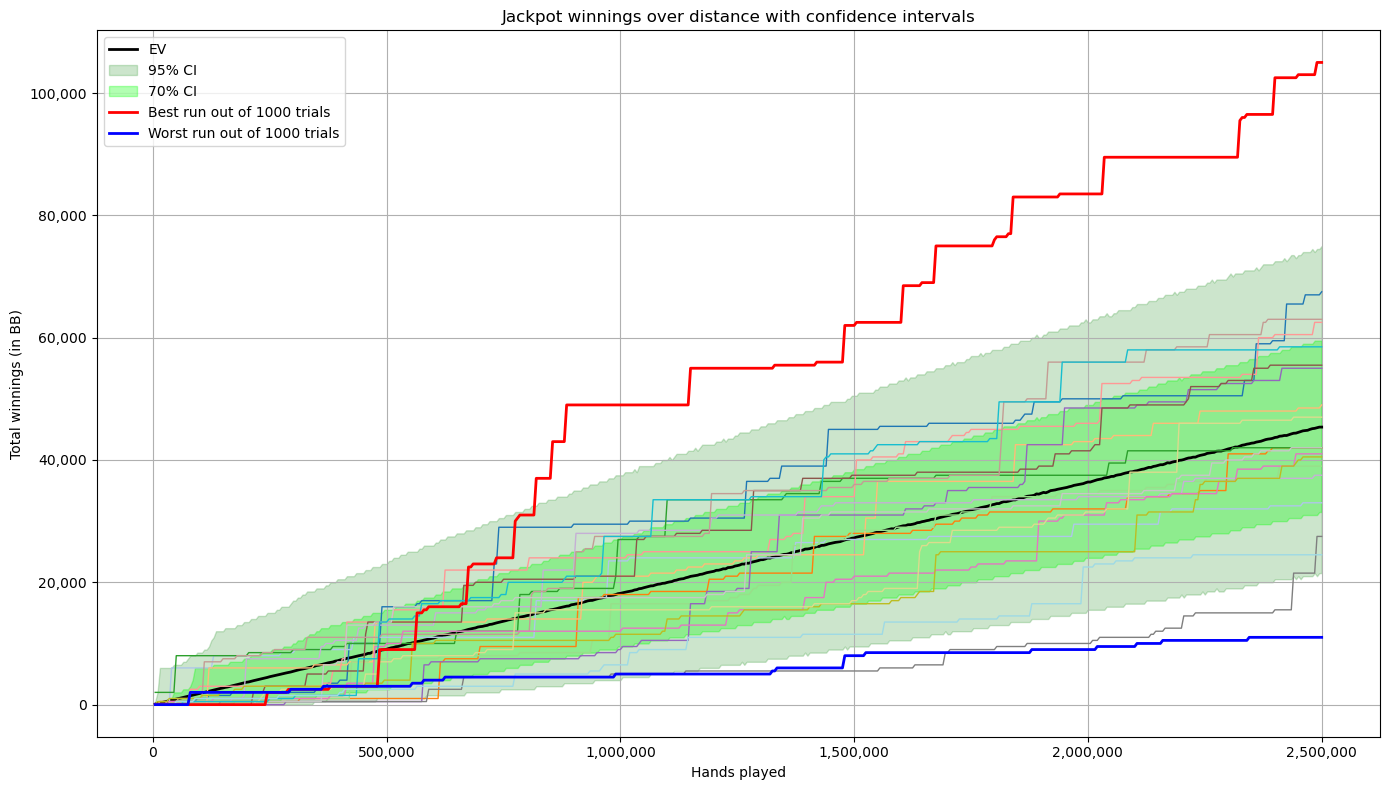

In [217]:
plot_jackpot_simulation(max_hands=2500000, seed=69)

Hands played: 2500000
Expected Value (EV): 45487.80 BB
Standard Deviation after 2500000 hands: 13665.56 BB (0.55 BB/100 hands)
70% Confidence Interval: [31500.00, 59500.00] BB ([1.260, 2.380] BB/100 hands)
95% Confidence Interval: [21500.00, 74500.00] BB ([0.860, 2.980] BB/100 hands)


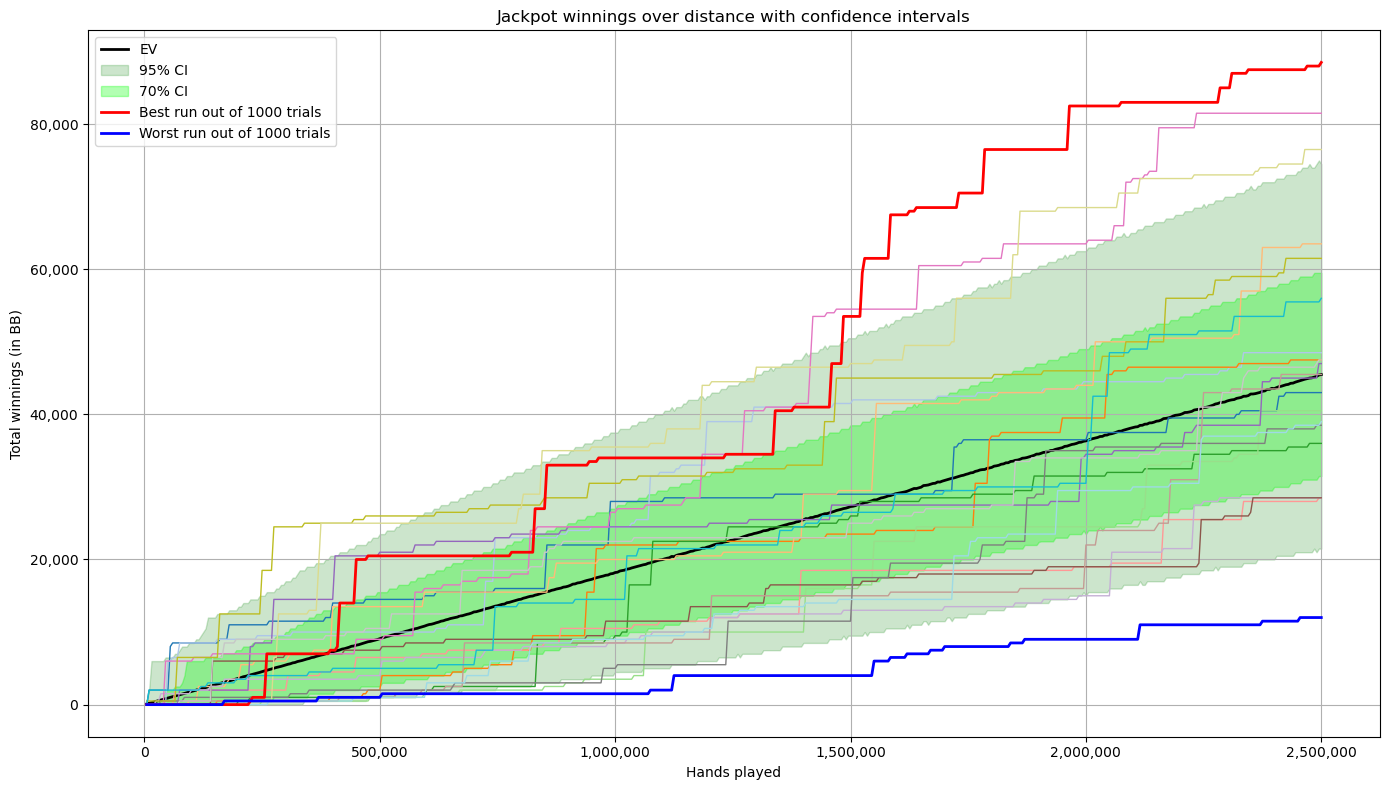

In [218]:
plot_jackpot_simulation(max_hands=2500000, seed=111)